In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
import utils
from utils import TimeSeries
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create a Retina object that can hold the entire Argus I array (4x4 checkerboard, 880um center-to-center)
# width: 4 x 880um = 3520um, but add radii: 3520um + 130um + 260um = 3910 um, but add padding for current spread -> 5000um
r_sampling = 50  # spatial sampling of retina
r = e2cm.Retina(axon_map='../retina_argus_s' + str(r_sampling) + '.npz', 
                sampling=r_sampling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [4]:
# Create Argus I electrode array 
# 4x4 checkerboard, 880um center-to-center, (almost) alternating electrode sizes

e_spacing = 880  # um
x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

# spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
#   .  o  .  o
#   o  .  o  .
#   .  o  .  o
#   o  .  o  .
r_arr = np.array([260, 520, 260, 520])
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*0

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(), y_coord.flatten().tolist(), h_arr.tolist())

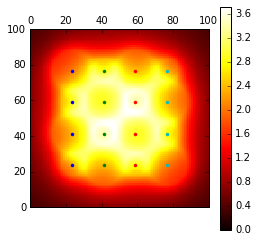

In [5]:
# show the cumulative current spread of the Argus I electrode arrangement
plt.matshow(e_all.current_spread(r.gridx, r.gridy), vmin=0, cmap='hot')

# also plot the center points of all the electrodes
plt.plot(x_coord/r_sampling+r.gridx.shape[0]/2, y_coord/r_sampling+r.gridx.shape[0]/2, '.')

plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()

In [6]:
e_rf = []
for e in e_all.electrodes:
    e_rf.append(e2cm.receptive_field(e, r.gridx, r.gridy, e_spacing))

In [7]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = r.electrode_ecs(e_all)

In [8]:
# create some pulse train
freq=20
dur=0.5
pulse_dur=.075/1000.
interphase_dur=.075/1000.
tsample=.005/1000.
current_amplitude=20,

p2pt = e2cm.Psycho2Pulsetrain(freq=freq, 
                              dur=dur, 
                              pulse_dur=pulse_dur, 
                              interphase_dur=interphase_dur, 
                              delay=0, 
                              tsample=tsample, 
                              current_amplitude=current_amplitude,
                              pulsetype='cathodicfirst',
                              stimtype='pulsetrain')

fps = 30
rs = 1/(fps*p2pt.tsample)

In [9]:
# The temporal model contains the cascade of operations that leads from pulse to percept:
tm = ec2b.TemporalModel(tsample=tsample)

In [10]:
# csvfile = '../../data/Horsager_2011/DataSummary_Horsager2011.csv'
# data = np.genfromtxt(csvfile, delimiter=',', dtype=None)

In [11]:
# pulse2percept(temporal_model, ecs, retina, stimuli, rs, dojit=True, n_jobs=-1, tol=.05)
%prun mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)

JoblibNameError: JoblibNameError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f8234c81a50, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ubuntu.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f8234c81a50, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ubuntu.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-31T21:03:03.868570', 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'session': '68AD1D1A7CF54E398622ECD37818C3A7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'68AD1D1A7CF54E398622ECD37818C3A7']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-31T21:03:03.868570', 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'session': '68AD1D1A7CF54E398622ECD37818C3A7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'68AD1D1A7CF54E398622ECD37818C3A7'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-31T21:03:03.868570', 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'session': '68AD1D1A7CF54E398622ECD37818C3A7', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7A7BDCE8F4D147178F07DFEC458BC955', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# pulse2percept(temporal_model, ecs, retina, sti...[p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-11-ef73967c9366>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])
   2830                 code = compiler(mod, cell_name, "single")
-> 2831                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f81f9302420, file "<ipython-input-11-ef73967c9366>", line 2>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2832                     return True
   2833 
   2834             # Flush softspace
   2835             if softspace(sys.stdout, 0):

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f81f9302420, file "<ipython-input-11-ef73967c9366>", line 2>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f81f9302420, file "<ipython-input-11-ef73967c9366>", line 2>
        self.user_global_ns = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/home/ubuntu/pulse2percept/python/notebooks/<ipython-input-11-ef73967c9366> in <module>()
      1 
----> 2 
      3 
      4 
      5 # pulse2percept(temporal_model, ecs, retina, stimuli, rs, dojit=True, n_jobs=-1, tol=.05)
      6 get_ipython().magic('prun mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')
      7 
      8 
      9 
     10 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, arg_s='prun mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')
   2158         compound statements.
   2159         """
   2160         # TODO: should we issue a loud deprecation warning here?
   2161         magic_name, _, magic_arg_s = arg_s.partition(' ')
   2162         magic_name = magic_name.lstrip(prefilter.ESC_MAGIC)
-> 2163         return self.run_line_magic(magic_name, magic_arg_s)
        self.run_line_magic = <bound method InteractiveShell.run_line_magic of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        magic_name = 'prun'
        magic_arg_s = 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)'
   2164 
   2165     #-------------------------------------------------------------------------
   2166     # Things related to macros
   2167     #-------------------------------------------------------------------------

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='prun', line='mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')
   2079             kwargs = {}
   2080             # Grab local namespace if we need it:
   2081             if getattr(fn, "needs_local_scope", False):
   2082                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2083             with self.builtin_trap:
-> 2084                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.prun of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)']
        kwargs = {}
   2085             return result
   2086 
   2087     def run_cell_magic(self, magic_name, line, cell):
   2088         """Execute the given cell magic.

...........................................................................
/home/ubuntu/pulse2percept/python/notebooks/<decorator-gen-54> in prun(self=<IPython.core.magics.execution.ExecutionMagics object>, parameter_s='mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', cell=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.prun>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', None), **k={})
    188     validate_type(magic_kind)
    189 
    190     # This is a closure to capture the magic_kind.  We could also use a class,
    191     # but it's overkill for just that one bit of state.
    192     def magic_deco(arg):
--> 193         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.prun>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', None)
        k = {}
    194 
    195         if callable(arg):
    196             # "Naked" decorator call (just @foo, no args)
    197             func = arg

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in prun(self=<IPython.core.magics.execution.ExecutionMagics object>, parameter_s='mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)', cell=None)
    274         opts, arg_str = self.parse_options(parameter_s, 'D:l:rs:T:q',
    275                                            list_all=True, posix=False)
    276         if cell is not None:
    277             arg_str += '\n' + cell
    278         arg_str = self.shell.input_splitter.transform_cell(arg_str)
--> 279         return self._run_with_profiler(arg_str, opts, self.shell.user_ns)
        self._run_with_profiler = <bound method ExecutionMagics._run_with_profiler...on.core.magics.execution.ExecutionMagics object>>
        arg_str = 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)\n'
        opts = {'D': [''], 'T': [''], 's': ['time'], 'l': []}
        self.shell.user_ns = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
    280 
    281     def _run_with_profiler(self, code, opts, namespace):
    282         """
    283         Run `code` with profiler.  Used by ``%prun`` and ``%run -p``.

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in _run_with_profiler(self=<IPython.core.magics.execution.ExecutionMagics object>, code='mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)\n', opts={'D': [''], 'T': [''], 's': ['time'], 'l': []}, namespace={'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...})
    296         # Fill default values for unspecified options:
    297         opts.merge(Struct(D=[''], l=[], s=['time'], T=['']))
    298 
    299         prof = profile.Profile()
    300         try:
--> 301             prof = prof.runctx(code, namespace, namespace)
        prof = <cProfile.Profile object>
        prof.runctx = <bound method Profile.runctx of <cProfile.Profile object>>
        code = 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)\n'
        namespace = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
    302             sys_exit = ''
    303         except SystemExit:
    304             sys_exit = """*** SystemExit exception caught in code being profiled."""
    305 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/cProfile.py in runctx(self=<cProfile.Profile object>, cmd='mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)\n', globals={'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}, locals={'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...})
     95         return self.runctx(cmd, dict, dict)
     96 
     97     def runctx(self, cmd, globals, locals):
     98         self.enable()
     99         try:
--> 100             exec(cmd, globals, locals)
        cmd = 'mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)\n'
        globals = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        locals = {'In': ['', "import sys\nsys.path.append('..')", "import numpy as np\nimport electrode2currentmap a...t as plt\nget_ipython().magic('matplotlib inline')", '# Create a Retina object that can hold the entir...mpling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)', '# Create Argus I electrode array \n# 4x4 checkerb...st(), y_coord.flatten().tolist(), h_arr.tolist())', '# show the cumulative current spread of the Argu...dx.shape[0], 0, r.gridx.shape[1]])\nplt.colorbar()', 'e_rf = []\nfor e in e_all.electrodes:\n    e_rf.ap....receptive_field(e, r.gridx, r.gridy, e_spacing))', '# We derive the effective current stimulation (e...e current (cs):\necs, cs  = r.electrode_ecs(e_all)', "# create some pulse train\nfreq=20\ndur=0.5\npulse_...'pulsetrain')\n\nfps = 30\nrs = 1/(fps*p2pt.tsample)", '# The temporal model contains the cascade of ope...percept:\ntm = ec2b.TemporalModel(tsample=tsample)', "# csvfile = '../../data/Horsager_2011/DataSummar...np.genfromtxt(csvfile, delimiter=',', dtype=None)", "# pulse2percept(temporal_model, ecs, retina, sti...2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)')"], 'Out': {5: <matplotlib.colorbar.Colorbar object>}, 'TimeSeries': <class 'utils.TimeSeries'>, '_': <matplotlib.colorbar.Colorbar object>, '_5': <matplotlib.colorbar.Colorbar object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
    101         finally:
    102             self.disable()
    103         return self
    104 

...........................................................................
/home/ubuntu/pulse2percept/python/notebooks/<string> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/ubuntu/pulse2percept/python/effectivecurrent2brightness.py in pulse2percept(temporal_model=<effectivecurrent2brightness.TemporalModel object>, ecs=array([[[ 0.06271976,  0.04030736,  0.01924087, ...0.01997406,
          0.04280604,  0.06789655]]]), retina=<electrode2currentmap.Retina object>, stimuli=[<electrode2currentmap.Psycho2Pulsetrain object>], rs=6666, dojit=False, n_jobs=8, tol=0.01)
    179                 # the current contributed by each electrode for that spatial location
    180 
    181     stim_data = np.array([s.data for s in stimuli])  # pulse train for each electrode
    182     sr_list = utils.parfor(calc_pixel, ecs_list, n_jobs=n_jobs,
    183                            func_args=[stim_data, temporal_model,
--> 184                                       rs,  stimuli[0].tsample, dojit])
        rs = 6666
        stimuli.tsample = undefined
        dojit = False
    185     bm = np.zeros(retina.gridx.shape + (sr_list[0].data.shape[-1], ))
    186     idxer = tuple(np.array(idx_list)[:, i] for i in range(2))
    187     bm[idxer] = [sr.data for sr in sr_list]
    188     return TimeSeries(sr_list[0].tsample, bm)

...........................................................................
/home/ubuntu/pulse2percept/python/utils.py in parfor(func=<function calc_pixel>, in_list=[array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), array([ 0.0651311 ,  0.04116247,  0.01944304,  0...4,  0.01114765,  0.01018205,
        0.00751697]), array([ 0.06816613,  0.04213852,  0.01964075,  0...7,  0.01135281,  0.01034121,
        0.00760418]), array([ 0.07051132,  0.0429114 ,  0.01983357,  0...3,  0.01156335,  0.01050351,
        0.00769239]), array([ 0.07407411,  0.04396331,  0.02002106,  0...3,  0.01177945,  0.01066899,
        0.0077816 ]), array([ 0.07626983,  0.04463594,  0.02020276,  0...3,  0.01200125,  0.01083771,
        0.0078718 ]), array([ 0.08041247,  0.04575621,  0.02037823,  0...2,  0.01222895,  0.01100971,
        0.00796298]), array([ 0.08373088,  0.04663628,  0.02054702,  0...4,  0.01246272,  0.01118505,
        0.00805513]), array([ 0.08548239,  0.04711984,  0.0207087 ,  0...8,  0.01270275,  0.01136377,
        0.00814824]), array([ 0.09055988,  0.04832273,  0.02086283,  0...6,  0.01294921,  0.01154591,
        0.0082423 ]), array([ 0.09184601,  0.04866439,  0.02100898,  0...7,  0.01320231,  0.01173152,
        0.00833729]), array([ 0.09754195,  0.04990139,  0.02114673,  0...6,  0.01346224,  0.01192064,
        0.0084332 ]), array([ 0.09818829,  0.05008307,  0.0212757 ,  0...2,  0.0137292 ,  0.01211331,
        0.00853001]), array([ 0.10444621,  0.05133408,  0.0213955 ,  0...2,  0.01400339,  0.01230955,
        0.0086277 ]), array([ 0.10427431,  0.05134369,  0.02150576,  0...9,  0.01428503,  0.01250941,
        0.00872624]), array([ 0.10713355,  0.05190489,  0.02160615,  0...6,  0.01457433,  0.0127129 ,
        0.00882561]), array([ 0.10981865,  0.05241506,  0.02169635,  0...1,  0.01487149,  0.01292006,
        0.00892579]), array([ 0.11677109,  0.0536187 ,  0.02177608,  0...2,  0.01517675,  0.01313089,
        0.00902674]), array([ 0.11450579,  0.0532687 ,  0.02184508,  0...7,  0.01549031,  0.01334541,
        0.00912844]), array([ 0.11704195,  0.05360616,  0.02190313,  0...3,  0.01581239,  0.01356364,
        0.00923084]), ...], out_shape=None, n_jobs=8, func_args=[array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False], func_kwargs={})
    138     p = Parallel(n_jobs=n_jobs, backend="multiprocessing", max_nbytes=1e6)
    139     d = delayed(func)
    140     d_l = []
    141     for in_element in in_list:
    142         d_l.append(d(in_element, *func_args, **func_kwargs))
--> 143     results = p(d_l)
        results = undefined
        p = Parallel(n_jobs=8)
        d_l = [(<function calc_pixel>, (array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.0651311 ,  0.04116247,  0.01944304,  0...4,  0.01114765,  0.01018205,
        0.00751697]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.06816613,  0.04213852,  0.01964075,  0...7,  0.01135281,  0.01034121,
        0.00760418]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07051132,  0.0429114 ,  0.01983357,  0...3,  0.01156335,  0.01050351,
        0.00769239]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07407411,  0.04396331,  0.02002106,  0...3,  0.01177945,  0.01066899,
        0.0077816 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07626983,  0.04463594,  0.02020276,  0...3,  0.01200125,  0.01083771,
        0.0078718 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08041247,  0.04575621,  0.02037823,  0...2,  0.01222895,  0.01100971,
        0.00796298]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08373088,  0.04663628,  0.02054702,  0...4,  0.01246272,  0.01118505,
        0.00805513]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08548239,  0.04711984,  0.0207087 ,  0...8,  0.01270275,  0.01136377,
        0.00814824]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09055988,  0.04832273,  0.02086283,  0...6,  0.01294921,  0.01154591,
        0.0082423 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09184601,  0.04866439,  0.02100898,  0...7,  0.01320231,  0.01173152,
        0.00833729]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09754195,  0.04990139,  0.02114673,  0...6,  0.01346224,  0.01192064,
        0.0084332 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09818829,  0.05008307,  0.0212757 ,  0...2,  0.0137292 ,  0.01211331,
        0.00853001]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10444621,  0.05133408,  0.0213955 ,  0...2,  0.01400339,  0.01230955,
        0.0086277 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10427431,  0.05134369,  0.02150576,  0...9,  0.01428503,  0.01250941,
        0.00872624]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10713355,  0.05190489,  0.02160615,  0...6,  0.01457433,  0.0127129 ,
        0.00882561]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10981865,  0.05241506,  0.02169635,  0...1,  0.01487149,  0.01292006,
        0.00892579]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11677109,  0.0536187 ,  0.02177608,  0...2,  0.01517675,  0.01313089,
        0.00902674]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11450579,  0.0532687 ,  0.02184508,  0...7,  0.01549031,  0.01334541,
        0.00912844]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11704195,  0.05360616,  0.02190313,  0...3,  0.01581239,  0.01356364,
        0.00923084]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), ...]
    144 
    145     if out_shape is not None:
    146         return np.array(results).reshape(out_shape)
    147     else:

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=8), iterable=[(<function calc_pixel>, (array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.0651311 ,  0.04116247,  0.01944304,  0...4,  0.01114765,  0.01018205,
        0.00751697]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.06816613,  0.04213852,  0.01964075,  0...7,  0.01135281,  0.01034121,
        0.00760418]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07051132,  0.0429114 ,  0.01983357,  0...3,  0.01156335,  0.01050351,
        0.00769239]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07407411,  0.04396331,  0.02002106,  0...3,  0.01177945,  0.01066899,
        0.0077816 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.07626983,  0.04463594,  0.02020276,  0...3,  0.01200125,  0.01083771,
        0.0078718 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08041247,  0.04575621,  0.02037823,  0...2,  0.01222895,  0.01100971,
        0.00796298]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08373088,  0.04663628,  0.02054702,  0...4,  0.01246272,  0.01118505,
        0.00805513]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.08548239,  0.04711984,  0.0207087 ,  0...8,  0.01270275,  0.01136377,
        0.00814824]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09055988,  0.04832273,  0.02086283,  0...6,  0.01294921,  0.01154591,
        0.0082423 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09184601,  0.04866439,  0.02100898,  0...7,  0.01320231,  0.01173152,
        0.00833729]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09754195,  0.04990139,  0.02114673,  0...6,  0.01346224,  0.01192064,
        0.0084332 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.09818829,  0.05008307,  0.0212757 ,  0...2,  0.0137292 ,  0.01211331,
        0.00853001]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10444621,  0.05133408,  0.0213955 ,  0...2,  0.01400339,  0.01230955,
        0.0086277 ]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10427431,  0.05134369,  0.02150576,  0...9,  0.01428503,  0.01250941,
        0.00872624]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10713355,  0.05190489,  0.02160615,  0...6,  0.01457433,  0.0127129 ,
        0.00882561]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.10981865,  0.05241506,  0.02169635,  0...1,  0.01487149,  0.01292006,
        0.00892579]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11677109,  0.0536187 ,  0.02177608,  0...2,  0.01517675,  0.01313089,
        0.00902674]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11450579,  0.0532687 ,  0.02184508,  0...7,  0.01549031,  0.01334541,
        0.00912844]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), (<function calc_pixel>, (array([ 0.11704195,  0.05360616,  0.02190313,  0...3,  0.01581239,  0.01356364,
        0.00923084]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {}), ...])
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=8)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
NameError                                          Wed Aug 31 21:03:04 2016
PID: 1884                   Python 3.5.2: /home/ubuntu/anaconda3/bin/python
...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function calc_pixel>, (array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/ubuntu/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function calc_pixel>
        args = (array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), array([[  0.,   0.,   0., ..., -20., -20., -20.]]), <effectivecurrent2brightness.TemporalModel object>, 6666, 5e-06, False)
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/ubuntu/pulse2percept/python/effectivecurrent2brightness.py in calc_pixel(ecs_vector=array([ 0.06271976,  0.04030736,  0.01924087,  0...5,  0.01094771,  0.01002597,
        0.00743076]), stim_data=array([[  0.,   0.,   0., ..., -20., -20., -20.]]), temporal_model=<effectivecurrent2brightness.TemporalModel object>, rs=6666, tsample=5e-06, dojit=False)
    188     return TimeSeries(sr_list[0].tsample, bm)
    189 
    190 
    191 def calc_pixel(ecs_vector, stim_data, temporal_model, rs, tsample, dojit='False'):
    192     ecm = e2cm.ecm(ecs_vector, stim_data, tsample)
--> 193     sr = temporal_model.model_cascade(ecm, dojit=dojit)
        sr = undefined
        temporal_model.model_cascade = <bound method TemporalModel.model_cascade of <effectivecurrent2brightness.TemporalModel object>>
        ecm = <utils.TimeSeries object>
        dojit = False
    194     # del temporal_model, ecm
    195     # gc.collect()
    196     sr.resample(rs)
    197     return sr

...........................................................................
/home/ubuntu/pulse2percept/python/effectivecurrent2brightness.py in model_cascade(self=<effectivecurrent2brightness.TemporalModel object>, ecm=<utils.TimeSeries object>, dojit=False)
    142 
    143     def model_cascade(self, ecm, dojit):
    144         # FIXME need to make sure ecm.tsample == self.tsample
    145         # Would it every vary within an experiment? across electrodes?
    146 
--> 147         fr = self.fast_response(ecm, dojit=dojit)
        fr = undefined
        self.fast_response = <bound method TemporalModel.fast_response of <effectivecurrent2brightness.TemporalModel object>>
        ecm = <utils.TimeSeries object>
        dojit = False
    148         # # ca = self.charge_accumulation(fr, ecm)
    149         # # this line deleted because charge accumulation now modeled at the 
    150         # # elecrode level as accumulated voltage
    151         sn = self.stationary_nonlinearity(fr)

...........................................................................
/home/ubuntu/pulse2percept/python/effectivecurrent2brightness.py in fast_response(self=<effectivecurrent2brightness.TemporalModel object>, b1=<utils.TimeSeries object>, dojit=False)
     94            Temporal signal to process (ecm).
     95         dojit : bool, optional
     96            If True (default), 
     97         """
     98         return self.tsample * utils.sparseconv(self.gamma_n1_tau1,
---> 99                                              stim.data,
    100                                              dojit)
    101         # return TimeSeries(self.tsample, R1)
    102 
    103     def charge_accumulation(self, fast_response, stimulus):

NameError: name 'stim' is not defined
___________________________________________________________________________

In [ ]:
plt.matshow(mov.data[:, :, 10], cmap='gray', vmin=0)
plt.colorbar()